# A four-headed cat state

Author: Guillaume Thekkadath

In this tutorial, we numerically simulate the protocol proposed in [arXiv:1908.10314](https://arxiv.org/abs/1908.10314) for engineering superpositions of coherent states. In particular we look at how to make a coherent superposition of four coherent states, a four-headed cat state.

In [ ]:
import numpy as np
from qutip import wigner, Qobj, wigner_cmap

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
%matplotlib inline
%config InlineBackend.figure_formats=['svg']

import strawberryfields as sf
from strawberryfields.ops import *
from thewalrus.quantum import state_vector, density_matrix

## Ideal preparation

Here we setup some basic parameters, like the value of the photon-number-resolving detectors we will use to herald and the parameters of the different Gaussian unitaries.

In [2]:
Lambda = 0.999 # As explained in the paper, the four-component cat state scheme works less well for finite squeezing.
r = np.arctanh(Lambda) 
fourCatSize = 14 # One obtains a better fidelity when this number is an integer (see paper for explanation)
# As per scheme, we first prepare a two-component cat state with half the size of the desired four-component cat
twoCatSize = fourCatSize / 2 
alpha = np.sqrt(twoCatSize) 
nModes = 5
nMax = 30
detOutcome1 = int(round(twoCatSize))
detOutcome2 = int(round(fourCatSize))
print(detOutcome1,detOutcome2)

7 14


Now we setup a 3-mode quantum circuit in Strawberry Fields and obtain the covariance matrix and vector of means of the Gaussian state.

In [3]:
nmodes = 5
prog = sf.Program(nmodes)
eng = sf.Engine("gaussian")
with prog.context as q:
    Dgate(1j*alpha)|q[0]
    S2gate(r)|(q[1],q[2])
    BSgate()|(q[0],q[1])
    Dgate(1j*alpha)|q[2]
    S2gate(r)|(q[3],q[4])
    BSgate()|(q[2],q[3])
state = eng.run(prog).state
mu = state.means()
cov = state.cov()

In [4]:
# Here we use the sf circuit drawer and standard linux utilities 
# to generate an svg representing the circuit
file, _ = prog.draw_circuit()
filepdf = file[0:-3]+"pdf"
filepdf = filepdf.replace("circuit_tex/","")
filecrop = filepdf.replace(".pdf","-crop.pdf")
name = "four_cat_circuit.svg"
!pdflatex  $file > /dev/null 2>&1
!pdfcrop $filepdf > /dev/null 2>&1
!pdf2svg $filecrop $name

Here is a graphical representation of the circuit. It is always assumed that the input is vacuum in all the modes. <br>
![img](./four_cat_circuit.svg)

We can now inspect the covariance matrix and vector of means. Note that the vector of means is non-zero since we used a displacement gate.

In [5]:
np.set_printoptions(linewidth=120)
print(np.round(mu,3))
print(np.round(cov,3))

[0.    0.    0.    0.    0.    3.742 3.742 3.742 3.742 0.   ]
[[ 500.25  -499.25  -499.75  -499.75     0.       0.      -0.       0.       0.       0.   ]
 [-499.25   500.25   499.75   499.75     0.      -0.       0.      -0.      -0.       0.   ]
 [-499.75   499.75   999.5      0.    -706.753    0.      -0.       0.      -0.       0.   ]
 [-499.75   499.75     0.     999.5    706.753    0.      -0.      -0.       0.      -0.   ]
 [   0.       0.    -706.753  706.753  999.5      0.       0.       0.      -0.       0.   ]
 [   0.      -0.       0.       0.       0.     500.25  -499.25   499.75   499.75     0.   ]
 [  -0.       0.      -0.      -0.       0.    -499.25   500.25  -499.75  -499.75     0.   ]
 [   0.      -0.       0.      -0.       0.     499.75  -499.75   999.5     -0.     706.753]
 [   0.      -0.      -0.       0.      -0.     499.75  -499.75    -0.     999.5   -706.753]
 [   0.       0.       0.      -0.       0.       0.       0.     706.753 -706.753  999.5  ]]


We now use the walrus to obtain the Fock representation of the heralded state when modes 0 and 1 are heralded in the value $n=7$ and modes 2 and 3 are heralded in the value $n=14$. This information is stored in the variable `psi`. We also calculate the probability of success in heralding in the variable `p_psi`.

In [6]:
psi = state_vector(mu, cov, post_select={0:detOutcome1, 1:detOutcome1, 2:detOutcome2, 3:detOutcome2}, 
                   normalize=False, cutoff=nMax)
p_psi = np.linalg.norm(psi)
psi = psi / p_psi
print("The probability of successful heralding is ", np.round(p_psi**2,10))

The probability of successful heralding is  4e-09


We now plot the photon-number distribution of the heralded state. Note that the state only has even photon components.

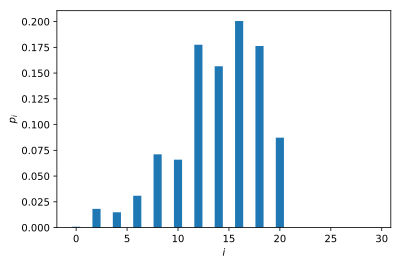

In [7]:
plt.bar(np.arange(nMax),np.abs(psi)**2)
plt.xlabel("$i$")
plt.ylabel(r"$p_i$")
plt.show()

We can now plot the Wigner function of the heralded state,

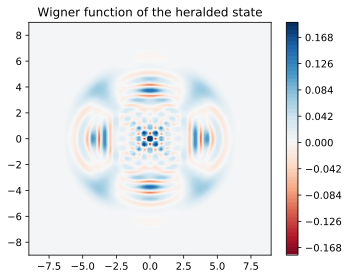

In [8]:
grid = 100
xvec = np.linspace(-9,9,grid)
Wp = wigner(Qobj(psi), xvec, xvec)
wmap = wigner_cmap(Wp)
sc1 = np.max(Wp)
nrm = mpl.colors.Normalize(-sc1, sc1)
fig, axes = plt.subplots(1, 1, figsize=(5, 4))
plt1 = axes.contourf(xvec, xvec, Wp, 60,  cmap=cm.RdBu, norm=nrm)
axes.contour(xvec, xvec, Wp, 60,  cmap=cm.RdBu, norm=nrm)
axes.set_title("Wigner function of the heralded state");
cb1 = fig.colorbar(plt1, ax=axes)
fig.tight_layout()
plt.show()

and a cut of the Wigner function along $p=0$.

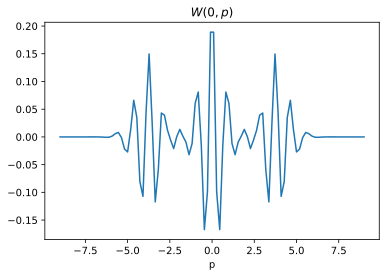

In [9]:
plt.plot(xvec, Wp[:,grid//2])
plt.title(r"$W(0,p)$")
plt.xlabel(r"p")
plt.show()

In [10]:
%reload_ext version_information
%version_information qutip, strawberryfields, thewalrus

Software versions
Python 3.6.8 64bit [GCC 7.3.0]
IPython 7.2.0
OS Linux 4.15.0 58 generic x86_64 with debian stretch sid
qutip 4.3.1
strawberryfields 0.12.0-dev
thewalrus 0.8.0-dev
Wed Sep 18 17:07:02 2019 EDT